In [12]:
# Make sure dependencies are installed
!{sys.executable} -m pip install pandas numpy seaborn sklearn matplotlib

In [20]:
# Author: Shane Arcaro and Nicholas DeLello
# Date: 4/26/2022
# Assignment: Final Project

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_selection import f_regression

In [ ]:


# Read the data
data = pd.read_csv('../data/fetal_health-1.csv')

[1. 2. 3.] [1655  295  176]


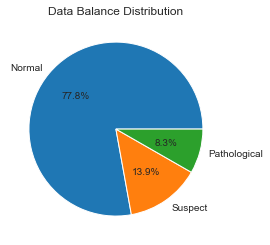

In [9]:
# Three classes: normal, suspect, pathological

# ===============================
#           T A S K # 1
# ===============================

# Get X and Y values from the data setcd cd
X = data.iloc[:, : -1]
Y = data.iloc[:, -1]

# Find and print classification values
values, count = np.unique(Y, return_counts=True)
print(values, count)
# Function used to show percentage on pi chart
def formatPercentage(pct):
    return "{:1.1f}%".format(pct)


# Data is very unbalanced: Normal: 1655, Suspect: 295, Pathological: 176
labels = ['Normal', 'Suspect', 'Pathological']
plt.pie(count, labels=labels, autopct=formatPercentage)
plt.title('Data Balance Distribution')
plt.show()

[1. 2. 3.] [750 750 750]


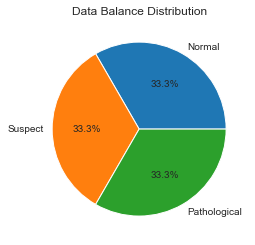

In [17]:
# How to fix imbalanced data? One way is to oversample data
data_majority1 = data[Y == 1]
data_minority2 = data[Y == 2]
data_minority3 = data[Y == 3]

# Number of data points in new sample size
resample_size = 750

# Resample the data, so there's 750 points in each set
data_sample_majority1 = resample(data_majority1, replace=False, n_samples=resample_size)
data_sample_minority2 = resample(data_minority2, replace=True, n_samples=resample_size)
data_sample_minority3 = resample(data_minority3, replace=True, n_samples=resample_size)

# Split the resampled data
data_sample = pd.concat([data_sample_majority1, data_sample_minority2, data_sample_minority3])
x_distribution = data_sample.iloc[:, : -1]
y_distribution = data_sample.iloc[:, -1]
x_distribution_train, x_distribution_test, y_distribution_train, y_distribution_test = train_test_split(x_distribution,
                                                                                                        y_distribution)

# Find and print classification values
values, count = np.unique(y_distribution, return_counts=True)
print(values, count)

# Data was Normal: 1655, Suspect: 295, Pathological: 176, is now evenly split, 750 for each
labels = ['Normal', 'Suspect', 'Pathological']
plt.pie(count, labels=labels, autopct=formatPercentage)
plt.title('Data Balance Distribution')
plt.show()

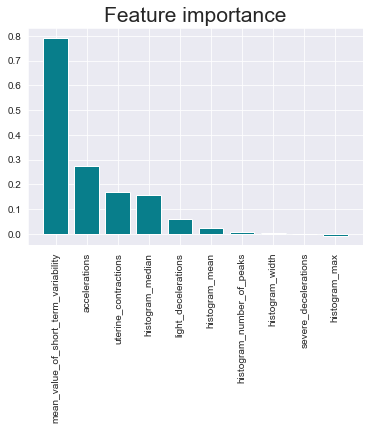

mean_value_of_short_term_variability	P-value: 0.2884	Not 95% confident	Not 90% confident
accelerations	P-value: 0.0000	95% confident	90% confident
uterine_contractions	P-value: 0.0000	95% confident	90% confident
histogram_median	P-value: 0.0000	95% confident	90% confident
light_decelerations	P-value: 0.0000	95% confident	90% confident
histogram_mean	P-value: 0.0000	95% confident	90% confident
histogram_number_of_peaks	P-value: 0.7504	Not 95% confident	Not 90% confident
histogram_width	P-value: 0.2589	Not 95% confident	Not 90% confident
severe_decelerations	P-value: 0.0000	95% confident	90% confident
histogram_max	P-value: 0.0039	95% confident	90% confident


In [81]:

# ===============================
#           T A S K # 2
# ===============================

# Get the P-values for each feature
_p_values = f_regression(x_distribution_train, y_distribution_train)[1]
columns = x_distribution_train.columns
p_values = {columns[i]: _p_values[i] for i in range(len(columns))}

# Get feature importance using Random Forest Regression
model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000, warm_start=True).fit(x_distribution_train, y_distribution_train)
importance = pd.DataFrame(data={
    'Attribute': x_distribution_train.columns,
    'Importance': model.coef_[0]
})
importance = importance.sort_values(by='Importance', ascending=False)[:10]

plt.bar(x=importance['Attribute'], height=importance['Importance'], color='#087E8B')
plt.title('Feature importance', size=21)
plt.xticks(rotation='vertical')
plt.show()

for _, entry in importance.iterrows():
    name = entry["Attribute"]
    p_value = p_values[name]
    print(name, "P-value: {:0.4f}".format(p_value), "95% confident" if p_value < 0.05 else "Not 95% confident", "90% confident" if p_value < 0.1 else "Not 90% confident", sep="\t")

In [51]:
from sklearn.calibration import CalibratedClassifierCV

# ===============================
#           T A S K # 3
# ===============================

# This is a multiclass problem that can be treated as regression
# Just need 2 different models to classify the features into the three fetal health states
# Using Statify classifier and RandomForest classifier

# Create stratify classifier
x_stratify_train, x_stratify_test, y_stratify_train, y_stratify_test = train_test_split(x_distribution, y_distribution,
                                                                                        test_size=0.3,
                                                                                        stratify=y_distribution)
model_stratify = SGDClassifier().fit(x_stratify_train, y_stratify_train)
y_prediction_stratify = model_stratify.predict(x_stratify_test)
model_proba = CalibratedClassifierCV(model_stratify, cv="prefit").fit(x_stratify_train, y_stratify_train)
y_prediction_stratify_prob = model_proba.predict_proba(x_stratify_test)

# Create Random Forest classifier
model_stratify_randomforest = RandomForestClassifier().fit(x_stratify_train, y_stratify_train)
y_predicition_stratify_randomforest = model_stratify_randomforest.predict(x_stratify_test)

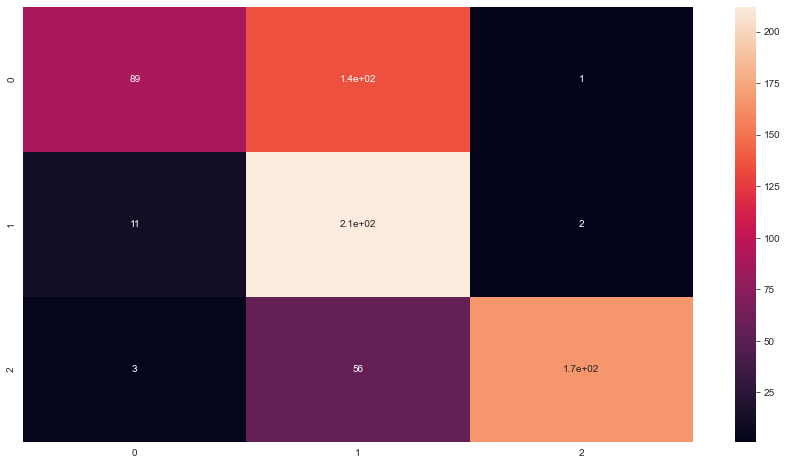

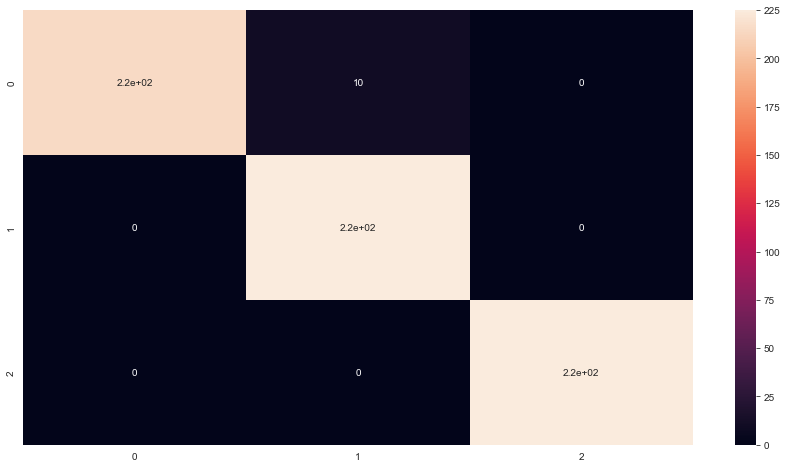

In [16]:

# ===============================
#           T A S K # 4
# ===============================

confusionmatrix = confusion_matrix(y_stratify_test, y_prediction_stratify)
plt.figure(figsize=(15, 8))
sns.heatmap(confusionmatrix, annot=True)
plt.show()

confusionmatrix_forest = confusion_matrix(y_stratify_test, y_predicition_stratify_randomforest)
plt.figure(figsize=(15, 8))
sns.heatmap(confusionmatrix_forest, annot=True)
plt.show()

In [80]:
from sklearn.metrics import roc_auc_score

# ===============================
#           T A S K # 5
# ===============================

# Stratify scores
print("Area Under ROC:      ", roc_auc_score(y_stratify_test, y_prediction_stratify_prob, multi_class="ovo"))
print("F1 Score:            ", f1_score(y_stratify_test, y_prediction_stratify, average="weighted"))
# Should pos_label be 1, 2, or 3? I'm not sure what the 1/2/3 in y_stratify_test represent, but it's gotta be one of those three
print("Area Under Precision:", precision_recall_curve(y_stratify_test, y_prediction_stratify, pos_label=3))

Area Under ROC:       0.9105810699588478
F1 Score:             0.7291014277682328
Area Under Precision: (array([0.33333333, 0.59598854, 0.9009434 , 1.        ]), array([1.        , 0.92444444, 0.84888889, 0.        ]), array([1., 2., 3.]))
